In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import sys
import model_fire_evacuation
sys.path.append('../vae')
import data_setup, visualization, model_utils, engine
from torch.utils.data import Dataset, DataLoader

os.environ['KMP_DUPLICATE_LIB_OK']='True'

ModuleNotFoundError: No module named 'umap'

#Install UMAP using pip install umap-learn

In [ ]:

torch.manual_seed(42)

Hyperparameters

In [ ]:
# Setup hyperparameters
NUM_EPOCHS = 200
INPUT_SIZE = 2
NUM_HIDDEN_LAYERS = 3
BATCH_SIZE = 64
HIDDEN_UNITS = 64
LATENT_DIMS = 2
LEARNING_RATE = 0.005
KL_BETA = 1

Set paths

In [ ]:
model_path = "../vae/models/"
image_path = "../vae/images/"

Scaling function

In [ ]:
# Define the scaling function
def scale_to_zero_one(x):
    min_val = x.min()
    max_val = x.max()
    scale = 1.0 / (max_val - min_val)
    shift = -min_val * scale
    # Convert [x, y] coordinates to a PyTorch tensor
    x_tensor = torch.tensor(x, dtype=torch.float32)
    return x_tensor * scale + shift


In [ ]:
# Load the training data
train_data = np.load('./dataset/FireEvac_train_set.npy')
test_data = np.load('./dataset/FireEvac_test_set.npy')

print("Training data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)
print(train_data[0])

In [ ]:
train_data = scale_to_zero_one(train_data)
test_data = scale_to_zero_one(test_data)

Create dataset

In [ ]:
class Fire_Evac_Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.Tensor(self.data[idx])

train_dataset = Fire_Evac_Dataset(train_data)
test_dataset = Fire_Evac_Dataset(test_data)

# Create DataLoader instances for training and testing
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X in train_loader:
    print("Batch shape:", X.shape)
    break

In [ ]:
# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
# Load the training dataset

# Extract x and y positions for training data
x_train = train_dataset[:, 0]
y_train = train_dataset[:, 1]

# Extract x and y positions for test data
x_test = test_dataset[:, 0]
y_test = test_dataset[:, 1]

# Create a scatter plot for training data (blue color)
plt.scatter(x_train, y_train, marker='x', s=15, color='blue', label='Training Data')

# Create a scatter plot for test data (red color)
plt.scatter(x_test, y_test, marker='+', s=15, color='red', label='Test Data')

# Set plot labels and title
plt.title('FireEvac Training and Test Datasets Scatter Plot')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Show legend
plt.legend()

# Show the plot
plt.show()

Create model

In [ ]:
# Create model 
vae = model_fire_evacuation.VAE(input_size=INPUT_SIZE,
                  num_hidden_layers=NUM_HIDDEN_LAYERS,
                  hidden_units=HIDDEN_UNITS,
                  latent_dims=LATENT_DIMS).to(device)
print(vae)

Train model

In [ ]:
# Set Optimizer
vae.cuda()
vae.float()
optimizer = torch.optim.Adam(vae.parameters(),
                             lr=LEARNING_RATE)
# Start training
results = engine.train(model=vae,
             train_dataloader=train_loader,
             test_dataloader=test_loader,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device,
             beta=KL_BETA,
             save_path = model_path)

Load model

In [ ]:
best_model = model_fire_evacuation.VAE(input_size=INPUT_SIZE,
                  num_hidden_layers=NUM_HIDDEN_LAYERS,
                  hidden_units=HIDDEN_UNITS,
                  latent_dims=LATENT_DIMS)

best_model.load_state_dict(torch.load(f=f"{model_path}best_model.pth", map_location=torch.device(device)))

Plot loss plots

In [ ]:
visualization.plot_loss(train_loss=results["train_loss"],
                        test_loss=results["test_loss"],
                        path= image_path)

visualization.plot_likelihood_and_kl_loss(train_likelihood=results["train_likelihood"], train_kl_loss=results["train_kl_loss"], test_kl_loss=results["test_kl_loss"], test_likelihood=results["test_likelihood"], path= image_path)


Get recovery data

In [ ]:
# recover test_data
vae.eval()
recover_data = best_model(torch.tensor(test_data))
recover_train = best_model(torch.tensor(train_data))    
#print(recover_data.shape)
recover_data = recover_data[0].mean.cpu().detach().numpy()
recover_train = recover_train[0].mean.cpu().detach().numpy()

print(recover_data.shape)
print(recover_data[0])

Plot reconstructed data

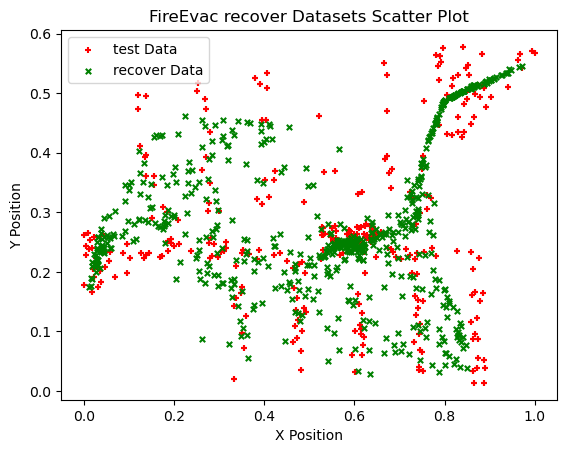

In [ ]:
# Extract x and y positions for generate data
x_recover = recover_data[:, 0]
y_recover = recover_data[:, 1]


# Create a scatter plot for recover data (blue color)
plt.scatter(test_data[:,0], test_data[:,1], marker='+', s=15, color='red', label='test Data')

plt.scatter(x_recover, y_recover, marker='x', s=15, color='green', label='recover Data')


# Set plot labels and title
plt.title('FireEvac recover Datasets Scatter Plot')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Show legend
plt.legend()

# Show the plot
plt.show()

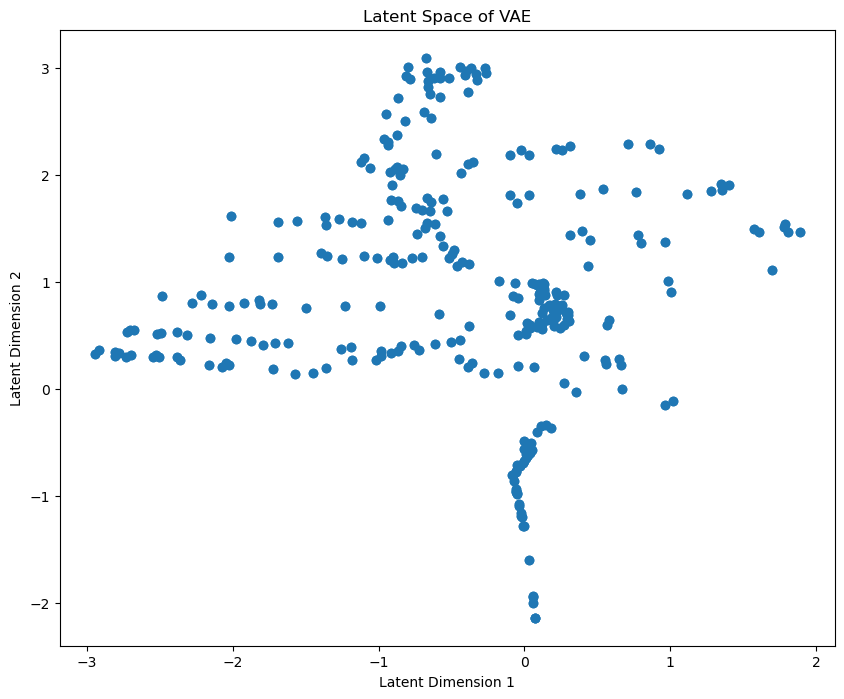

In [ ]:
visualization.plot_latent_fire_evacuation(model=vae.float().cpu(),
                                test_data=test_data,
                                path = "../vae/images/")

(1000, 2)


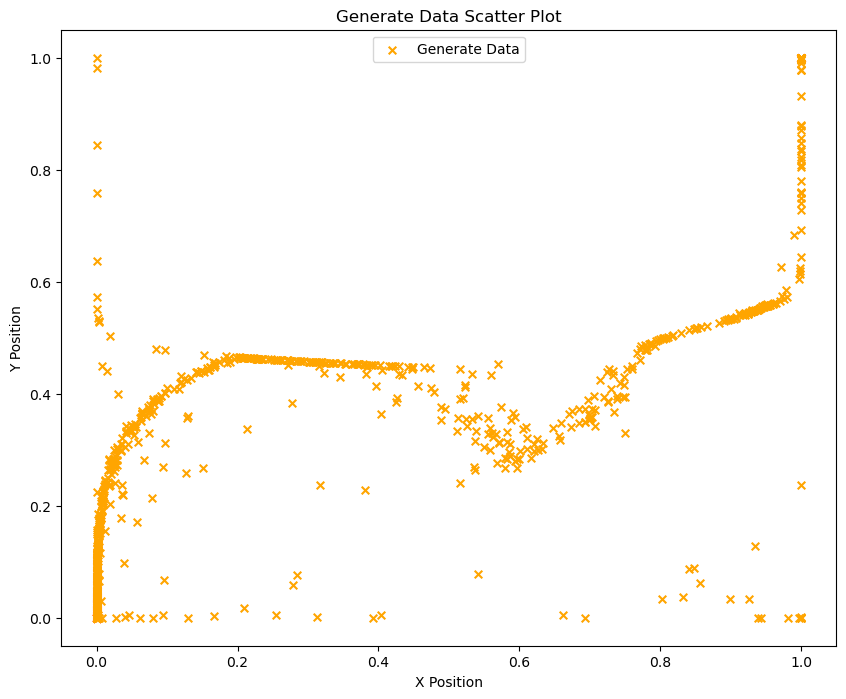

In [ ]:
vae.eval()
vae.double()
vae.cuda()

mean = [-0.5, 1]
covariance_matrix = [[1, 0.5], [0.5, 1]]
data_points = np.random.multivariate_normal(mean, covariance_matrix, 1000)

x_axis = data_points[:,0]
y_axis = data_points[:,1]

# generate_x, generate_y = np.meshgrid(x_axis, y_axis)
# generate_laten_space = np.column_stack((generate_x.flatten(), generate_y.flatten()))
print(data_points.shape)


generate_laten_space_cuda = torch.tensor(data_points).cuda()
x_hat = vae(generate_laten_space_cuda)
generate_data = x_hat[0].loc.detach().cpu().numpy()

# Create an plot
plt.figure(figsize=(10, 8))

# Scatter plot for test data (blue color)
plt.scatter(generate_data[:,0], generate_data[:,1], marker='x', s=30, color='orange', label='Generate Data')


# Set plot labels and title
plt.title('Generate Data Scatter Plot')
plt.xlabel('X Position')
plt.ylabel('Y Position')

# Show legend
plt.legend()

# Show the plot
plt.show()